In this notebook I investigate the effect of inequality reduction on GHG emissions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kde import *
from perc import *
%matplotlib inline


from wb_api_wraper import *

In [3]:
datadir = "csvdata/";


In [4]:
iso_to_name = pd.read_csv("iso3_to_wb_name.csv").set_index("iso3")["country"]

In [5]:
#number of persons per household
persdata=pd.read_csv("csvdata/PERSDATA.csv",).replace(iso_to_name)  #her emost of weights are 1 but some weights are 0.6
persdata.columns = map(str.lower, persdata.columns)
nb_people_in_hh =persdata.groupby(["country","hid"])["pid"].count()


C:\Users\Admin\Anaconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [6]:
#number of people per household
hhdata = pd.read_csv("csvdata/HHLDDATA.csv").replace(iso_to_name)
hhdata.columns = map(str.lower, hhdata.columns)
hhdata.set_index(["country","hid"],inplace="True")
nb_people_tot = hhdata["weight"]*nb_people_in_hh


In [56]:
tot_pop = nb_people_tot.reset_index().groupby("country")[0].sum()
tot_emis = (hh_emis*hhdata.weight).groupby(level=0).sum()
tot_emis

country
Albania         1.040662e+09
Armenia                  NaN
Bangladesh               NaN
Ghana           1.260871e+10
India           1.906669e+11
Iraq            3.202297e+10
Liberia         9.380252e+08
Malawi          1.989655e+09
Moldova         3.982440e+10
Niger           6.601154e+09
Rwanda          1.795978e+09
Senegal         8.885214e+09
Sierra Leone    1.653691e+09
Vietnam         5.715552e+10
dtype: float64

Data from World bank API

In [53]:
wb_pop = get_wb_mrv("SP.POP.TOTL","wb_pop")["wb_pop"]
wb_emis = get_wb_mrv("EN.ATM.CO2E.FF.KT","wb_emis")["wb_emis"]

In [57]:
wb_emis = wb_emis.ix[tot_emis.index]

In [64]:
tot_emis/wb_emis

country
Albania                    NaN
Armenia                    NaN
Bangladesh                 NaN
Ghana           1693805.518934
India                      NaN
Iraq                       NaN
Liberia         1788823.758953
Malawi          1877452.705637
Moldova                    NaN
Niger           5696680.335304
Rwanda          2473574.510851
Senegal         1941522.382588
Sierra Leone    1168304.614147
Vietnam                    NaN
dtype: float64

aggregates

In [50]:
(tot_pop/wb_pop).dropna()

country
Albania         0.412566
Armenia         1.148311
Ghana           0.872517
India           0.796689
Iraq            0.900637
Liberia         0.630027
Malawi          0.861687
Moldova         0.942429
Niger           0.933535
Rwanda          0.190569
Senegal         0.964585
Sierra Leone    0.971050
Vietnam         0.995079
dtype: float64

In [36]:
#emissions per household and per capita
hh_emi = pd.read_csv("csvdata/emissionsbyhousehold.csv").replace(iso_to_name)

In [22]:
hh_emi.rename(columns={"value": "hh_emis"},inplace=True)
hh_emis = hh_emi.set_index(["country", "hid"])["hh_emis"]
hh_emi_pc = hh_emis/nb_people_in_hh

In [48]:
wb_emis_pc=wb_emis_pc.ix[tot_emis.index]
wb_emis = wb_emis.ix[tot_emis.index] #kilotons, for some reason
wb_emis;

In [55]:
tot_emis/wb_emis

country
Africa                                                              NaN
Albania                                                             NaN
Algeria                                                             NaN
Angola                                                              NaN
Armenia                                                             NaN
Bangladesh                                                          NaN
Benin                                                               NaN
Botswana                                                            NaN
Burkina Faso                                                        NaN
Burundi                                                             NaN
Cape Verde                                                          NaN
Central African Republic                                            NaN
Chad                                                                NaN
Comoros                                                 

In [52]:
(tot_emis/tot_pop)/(wb_emis_pc)

country
Albania           592.110689
Armenia                  NaN
Bangladesh               NaN
Ghana            1504.101523
India             114.710735
Iraq              287.298917
Liberia          1716.693529
Malawi           1709.371799
Moldova          8712.166818
Niger            4464.382217
Rwanda          14598.402047
Senegal          1195.725340
Sierra Leone     2332.360640
Vietnam           370.502840
dtype: float64

In [ ]:
#expenditures per capita
hh_exp = pd.read_csv("csvdata/PerCapitaExpenditures.csv").replace(iso_to_name)
hh_exp.rename(columns={"value": "hh_exp_pc"},inplace=True)
hh_exp.set_index(["country","hid"],inplace="True")

In [6]:
#builds dataframe indexed by country and hid with all the data
df = pd.DataFrame(hh_exp["hh_exp_pc"])
df["hh_emi"]=hh_emi["hh_emis"]
df["hh_emi_pc"]=hh_emi_pc
df["nb_people"]=nb_people
df["w"]=hop["weight"]
df["hh_emis_perdol"]=df["hh_emi_pc"]/df["hh_exp_pc"]

#Vietnam 
vn=df.ix["VNM",:]

In [8]:
def wavg(val_col_name, wt_col_name):
    """computes the average of val_col_name weighted by wt_col_name"""
    def inner(group):
        return (group[val_col_name] * group[wt_col_name]).sum() / group[wt_col_name].sum()
    #inner.__name__ = res_name
    return inner

In [10]:
flat_df =  df.reset_index()
country_list = flat_df.country.unique()

In [19]:
#Categories USD per day categories
income_bins = np.array([0,1,1.25,2,2.5,4]+[10*2.**i for i in range(0,15,1)]) 
income_cut = pd.cut(flat_df["hh_exp_pc"]/365, income_bins)

income_cut.unique()


array(['(4, 10]', '(2.5, 4]', '(10, 20]', '(2, 2.5]', '(0, 1]',
       '(1.25, 2]', '(40, 80]', '(20, 40]', '(1, 1.25]', '(80, 160]',
       '(1280, 2560]', '(320, 640]', '(2560, 5120]', '(5120, 10240]',
       '(160, 320]', '(640, 1280]', '(40960, 81920]'], dtype=object)

In [21]:
flat_df

,country,hid,hh_exp_pc,hh_emi,hh_emi_pc,nb_people,w,hh_emis_perdol
0,ALB,10001,2632.572754,1583.579468,791.789734,164.866913,82.433456,0.300767
1,ALB,10002,2355.229736,1412.645264,706.322632,164.866913,82.433456,0.299895
2,ALB,10004,1247.623535,1126.146484,375.382161,247.300369,82.433456,0.300878
3,ALB,10005,2026.052124,1321.820312,660.910156,164.866913,82.433456,0.326206
4,ALB,10006,2276.071533,1402.214355,701.107178,164.866913,82.433456,0.308034
5,ALB,10007,3929.436035,1170.854492,1170.854492,82.433456,82.433456,0.297970
6,ALB,1001,2096.687012,1983.275391,661.091797,1030.230743,343.410248,0.315303
7,ALB,1002,1740.827881,997.257263,498.628632,686.820496,343.410248,0.286432
8,ALB,1005,1774.202271,1025.978149,512.989075,686.820496,343.410248,0.289138
9,ALB,1006,1002.888489,670.682861,335.341431,686.820496,343.410248,0.334376


In [20]:
#
stats = pd.DataFrame()
grouped =flat_df.groupby(["country",income_cut])
stats["avg_emis_pc"]=grouped.apply(wavg('hh_emi_pc', 'w'))
stats["nb_people0"] =grouped["nb_people"].sum()
#stats.sort_index(inplace=True)
#stats["nb_people1"]=grouped["nb_people"]
stats

avg_emis_pc    nb_people0
country hh_exp_pc                                 
ALB     (0, 1]             81.000632  8.433458e+03
        (1, 1.25]         127.474799  1.514561e+04
        (1.25, 2]         186.023844  8.350561e+04
        (2, 2.5]          248.269952  7.020666e+04
        (2.5, 4]          355.556632  2.460258e+05
        (4, 10]           738.563032  5.560363e+05
        (10, 20]         1559.840269  1.834183e+05
        (20, 40]         3190.788216  2.975957e+04
        (40, 80]         6235.497741  2.823372e+03
GHA     (0, 1]            150.592764  7.286294e+06
        (1, 1.25]         237.481368  2.869826e+06
        (1.25, 2]         338.554593  5.830089e+06
        (2, 2.5]          469.723355  1.968684e+06
        (2.5, 4]          675.439443  2.659665e+06
        (4, 10]          1199.414704  1.531039e+06
        (10, 20]         2226.019785  1.889200e+05
        (20, 40]         3703.998216  6.052600e+04
        (40, 80]         8196.696038  1.850100e+04
        (80, 160]       18971.860539  1.534400e+04
        (160, 320]      21841.422911  4.788000e+03
        (320, 640]      52033.885710  2.044800e+04
        (1280, 2560]   297772.739376  3.820000e+03
        (2560, 5120]   288329.965185  4.047000e+03
        (5120, 10240]  536739.812500  5.160000e+02
IND     (0, 1]            218.156832  9.974430e+08
IRQ     (0, 1]            217.978966  9.989299e+05
        (1, 1.25]         285.820647  9.785053e+05
        (1.25, 2]         418.880688  4.708394e+06
        (2, 2.5]          550.447357  3.569014e+06
        (2.5, 4]          775.356237  8.393551e+06
...                              ...           ...
SEN     (2.5, 4]          987.822075  2.077766e+06
        (4, 10]          1955.711670  1.277568e+06
        (10, 20]         3827.477951  1.093210e+05
        (20, 40]         7001.584803  2.018100e+04
        (40, 80]         9515.622593  1.369000e+03
SLE     (0, 1]             73.400682  4.750004e+06
        (1, 1.25]         157.673852  4.327717e+05
        (1.25, 2]         219.097271  3.791184e+05
        (2, 2.5]          299.538794  1.137772e+05
        (2.5, 4]          416.794395  8.367447e+04
        (4, 10]           715.698342  3.632825e+04
        (10, 20]         1954.495427  2.496853e+04
        (20, 40]         3453.059572  2.703285e+04
        (40, 80]         6582.605510  1.691791e+04
        (80, 160]       30605.861887  9.072228e+03
        (160, 320]      24247.112237  7.636058e+03
        (320, 640]      25010.532590  2.468212e+03
        (640, 1280]     98425.681250  3.995334e+02
        (1280, 2560]   239915.975000  9.951290e+02
VNM     (0, 1]            119.413291  3.191544e+06
        (1, 1.25]         174.734223  3.515084e+06
        (1.25, 2]         257.065685  1.469378e+07
        (2, 2.5]          352.234986  1.112904e+07
        (2.5, 4]          510.128941  2.577314e+07
        (4, 10]           930.554210  2.642195e+07
        (10, 20]         1959.434768  3.669248e+06
        (20, 40]         3653.734602  6.948520e+05
        (40, 80]         6372.177489  1.359890e+05
        (80, 160]       11643.099177  3.742400e+04
        (160, 320]      21262.083984  5.412000e+03

[128 rows x 2 columns]

In [14]:
#stats.ix[c]
#country_stats

In [15]:
#for c in country_list:
#def lift_folks(country_stats):
def lift_folks(country_stats):
    #out = pd.DataFrame(index=country_stats.index)
    emis =pd.DataFrame(index=["emis"])
    out= country_stats.ix[:,["nb_people0"]]
    for i in range(1,10):
        nam = 'min'+str(income_bins[i])
        out[nam] = country_stats["nb_people0"]
        out.ix[i,nam] = country_stats.ix[0:i+1,"nb_people0"].sum()
        out.ix[0:i,nam] =0
        #emis[str(i)]= np.average(country_stats["avg_emis_pc"],weights=out[nam])
    return out
 #   stats.ix[c,[out.columns.values]]=out

In [16]:
emis_sce_country = pd.DataFrame()
#computes new emissions at once
for c in country_list:
    emis_sce_country[c]= stats.ix[c]["avg_emis_pc"].dot(lift_folks(stats.ix[c,:]))/(stats.ix[c]["nb_people0"].sum())
    
emis_sce_country    

ValueError: cannot set by positional indexing with enlargement

In [15]:
#emis_sce_country['tot']=emis_sce_country.sum(axis=1)  

In [16]:
(emis_sce_country/emis_sce_country.ix["nb_people0",:]-1)*100

,NER,VNM,IRQ,ALB,LBR
nb_people0,0.000000,0.000000,0.000000,0.000000,0.000000
min1.0,7.280904,0.301419,0.207580,0.042306,0.000479
min1.25,16.291987,1.268616,1.013520,0.191322,-0.000074
min2.0,33.196423,4.849300,3.707872,0.910815,0.001987
min2.5,60.748794,13.816669,10.772492,2.963962,0.004411
min4.0,87.794458,33.764682,25.356088,9.211427,0.016805
min5.0,169.305438,77.255305,61.862449,28.313121,0.079666
min10.0,370.500869,210.874279,179.134129,107.926858,0.709929
min20.0,606.810193,474.998117,400.836627,312.628480,6.544032
min40.0,817.974860,910.670072,831.263246,704.552941,34.454604


In [17]:
#paf = stats.reset_index().groupby("country").apply(lift_folks)
#paf.reset_index().groupby("country").apply(wavg("avg_emis_pc","nb_people1"))
#paf

In [18]:
#pd.concat([flat_df,pd.get_dummies(income_cut)],axis=1).set_index(["country","hid"])
income_cut = pd.cut(df["hh_exp_pc"]/365, income_bins)

income_dummies= pd.get_dummies(income_cut)
df= pd.concat([df,income_dummies],axis=1)
df

hh_exp_pc       hh_emi   hh_emi_pc    nb_people           w  \
country hid                                                                    
NER     10001   444.853180   787.420105  131.236684  3574.244751  595.707458   
        10002   186.074432   532.708130   53.270813  5957.074585  595.707458   
        10003   630.626465   721.418701  180.354675  2382.829834  595.707458   
        10004   188.829971   364.780273   60.796712  3574.244751  595.707458   
        10005   293.547577   587.608582   97.934764  3574.244751  595.707458   
        10006   229.803070   367.151855   73.430371  2978.537292  595.707458   
        10007   290.218567   369.896027   92.474007  2382.829834  595.707458   
        10008   149.411087   318.570129   45.510018  4169.952209  595.707458   
        10009   179.062973   408.274567   58.324938  4169.952209  595.707458   
        1001   1102.077515   668.601501  334.300751   378.638092  189.319046   
        10010   248.775970   647.809265   80.976158  4765.659668  595.707458   
        10011   294.250885   243.914215   81.304738  1787.122375  595.707458   
        10012   205.612061   176.351791   58.783930  1787.122375  595.707458   
        10013   437.387299   477.498413  159.166138  1787.122375  595.707458   
        10014   173.250137   424.091248   47.121250  5361.367126  595.707458   
        10015   220.731445   283.074829   70.768707  2382.829834  595.707458   
        10016   256.074432   429.147583   85.829517  2978.537292  595.707458   
        10017   102.584473   195.431580   27.918797  4169.952209  595.707458   
        10018   356.481262   445.140839   89.028168  2978.537292  595.707458   
        1002    381.757202   546.910278  109.382056   946.595230  189.319046   
        1003    623.133545   850.557068  212.639267   757.276184  189.319046   
        1004    232.908783   471.496796   67.356685  1325.233322  189.319046   
        1005    252.741821   363.047913   72.609583   946.595230  189.319046   
        1006    260.592957   630.533447   78.816681  1514.552368  189.319046   
        1007    254.184708   589.163879   73.645485  1514.552368  189.319046   
        1008    186.792175   487.560120   54.173347  1703.871414  189.319046   
        1009    249.580719   598.429504   74.803688  1514.552368  189.319046   
        101     604.180176  1807.920288  301.320048  2689.703796  448.283966   
        1010    144.654831   432.155090   43.215509  1893.190460  189.319046   
        10101   277.147827   783.863281   87.095920  6747.298462  749.699829   
...                    ...          ...         ...          ...         ...   
        3518    151.522552   362.003235   51.714748  2238.367493  319.766785   
        3601    591.928162   947.339233  236.834808  1181.005371  295.251343   
        3602    320.937012   798.369080   99.796135  2362.010742  295.251343   
        3603    726.011719   658.944702  219.648234   885.754028  295.251343   
        3604    787.481079   533.510193  266.755096   590.502686  295.251343   
        3605    324.590637   279.664642   93.221547   885.754028  295.251343   
        3606    403.738373   897.184509  112.148064  2362.010742  295.251343   
        3607    370.843262   632.817322  105.469554  1771.508057  295.251343   
        3608    290.054718   574.840881   82.120126  2066.759399  295.251343   
        3609    381.099884   847.520935  105.940117  2362.010742  295.251343   
        3610    242.807663   475.717194   67.959599  2066.759399  295.251343   
        3611    443.864960   384.868866  128.289622   885.754028  295.251343   
        3612    355.147430  1117.092407  101.553855  3247.764771  295.251343   
        3613    260.708344   435.301666   72.550278  1771.508057  295.251343   
        3614    321.064697   462.409210   92.481842  1476.256714  295.251343   
        3615    345.033539   686.845520   98.120789  2066.759399  295.251343   
        3616    389.820923  1044.126709  130.515839  2362.010742  295.251343   
        3617    7

In [19]:
stats.ix[:,"nb_people1"] = stats.ix[:,"nb_people"]
stats.ix[:,"nb_people1"]

KeyError: 'nb_people'

In [ ]:
stats.ix[pd.MultiIndex("ALB)]

In [ ]:
wp(vn["hh_exp_pc"],vn["nb_people"],np.arange(0,1,0.1))

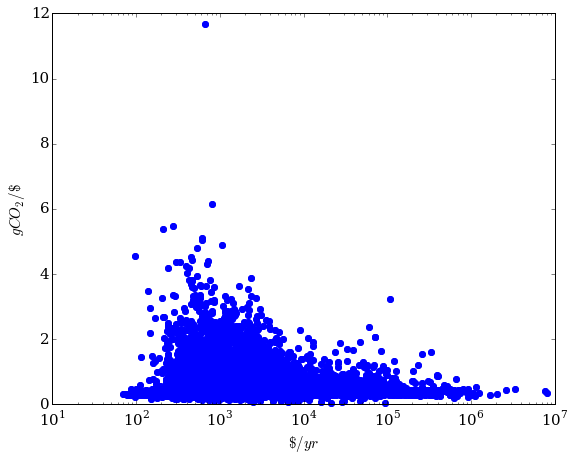

In [23]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(9,7))
plt.plot((df["hh_exp_pc"]),df["hh_emi_pc"]/df["hh_exp_pc"],color="blue",marker='.',markeredgewidth=1,linestyle='None',markersize=12,clip_on=False)
plt.xlabel("$\$/yr$")
plt.ylabel("$gCO_2/\$$")
plt.xscale("log")

In [20]:
stats.

SyntaxError: invalid syntax (<ipython-input-20-691de084c80a>, line 1)

In [21]:
def weighted_rolling_mean(x,y,w,kernel):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-21-5bcadc646562>, line 2)

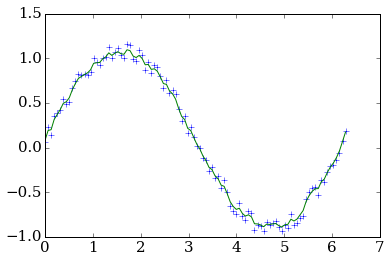

In [10]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
kr = KernelReg(y,x,'o')
plt.plot(x, y, '+')
y_pred, y_std = kr.fit(x)
plt.plot(x, y_pred)

In [94]:
def plot_distribution(y,w,thecolor="red"):
    hist, bin_edges = np.histogram(y,bins=100,weights=w,density=True)
    width = 0.5 * (bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    xs = np.linspace(center.min(),center.max(),300)
    plt.bar(center, hist, align='center', width=width,alpha=0.0,color=thecolor)
    density = gaussian_kde(y,weights=w)
    density._compute_covariance()
    plt.plot(xs,density(xs),linewidth=2,color=thecolor)


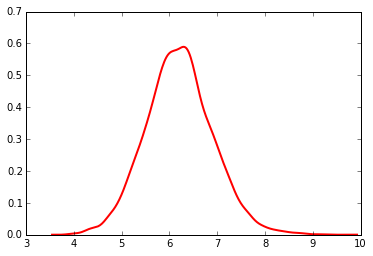

In [98]:
plot_distribution(np.log(vn.hh_emi_pc),vn.w)

